Для проноза значений целевых параметров: температура расплава и содержание в нём углерода, в каждый момент времени в ходе продувки созданим линейную, интерпретируемую модель

# Preprocess raw data
Начальные данные должны быть расположены относительно файла данного ноутбука в папке `data/raw` в распакованном виде csv-файлов

In [5]:
!python3 -V

Python 3.6.9


In [8]:
!python3 generate_dataset-9.py

Nas: 2
Shape: (2063, 98)
Nas: 0
Shape: (780, 98)
Nas: 0
Shape: (2061, 100)


# Libs

In [183]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

# Methods

In [10]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [185]:
def metric_tst(y_true, y_pred):

    delta_t = np.abs(np.array(y_true) - np.array(y_pred))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(y_true)

    return np.sum(hit_rate_t) / N

In [130]:
def process_data(df):
    df = df.copy()
    # Sorting
    df.sort_values('chugun_DATA_ZAMERA', inplace=True)
    df.drop(['chugun_DATA_ZAMERA','plavka_VR_NACH','plavka_VR_KON','NPLV'], axis=1, inplace=True)
    
    # VES/O2 has inf values
    if (df['VES/O2'] == np.inf).sum() > 0:
        df.loc[df['VES/O2'] == np.inf, 'VES/O2'] = df['VES/O2'].median()

    return df

# Data

In [16]:
train = pd.read_csv('data/processed/train.csv')
test = pd.read_csv('data/processed/test.csv')
train.shape, test.shape

((2061, 101), (780, 101))

In [131]:
df_train = process_data(train)
df_test = process_data(test)

# Pearson correlation
Посмотрим какие признаки линейно коррелируют с целевыми

In [132]:
df = df_train.copy()

In [133]:
df

,TST,C,chugun_VES,chugun_T,chugun_SI,chugun_MN,chugun_S,chugun_P,chugun_CR,chugun_NI,...,chronom_time_ППР,chronom_time_Подварка футеровки,chronom_time_Полусухое торкрет.,chronom_time_Продувка,chronom_time_Ремонт летки,chronom_time_Слив шлака,chronom_time_межпл. простой,gas_T_start_povalka,timer,VES/O2
0,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,...,0,0,0,1170,0,23,333,785.416687,412.0,12.747863
1,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,...,0,0,0,1230,0,39,422,846.875000,1384.0,6.097125
2,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,...,0,0,0,1226,0,27,307,831.597229,551.0,10.506452
3,1609,0.410,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,...,0,0,0,1058,0,21,700,826.041687,429.0,8.979007
4,1682,0.120,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,...,0,0,0,1239,0,24,464,809.722229,558.0,10.868674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056,1626,0.145,267200.0,1415.0,0.38,0.28,0.019,0.099,0.02,0.01,...,0,0,0,1063,0,148,470,772.569458,-646.0,21.026877
2057,1643,0.087,266800.0,1405.0,0.50,0.30,0.017,0.104,0.02,0.01,...,0,0,0,1108,0,16,765,812.152771,697.0,8.525566
2058,1615,0.141,276100.0,1398.0,0.61,0.31,0.025,0.115,0.03,0.01,...,0,0,0,1058,0,99,442,782.986084,-2888.0,12.272091
2059,1654,0.270,275800.0,1408.0,0.38,0.27,0.021,0.100,0.02,0.01,...,0,0,0,1169,0,75,454,779.513855,-1904.0,12.539862


In [98]:
X = df.drop(['TST','C'], axis=1)
tst = df.TST
c = df.C

In [99]:
tst_corr = X.corrwith(tst)
tst_corr.sort_values(ascending=False, inplace=True)
c_corr = X.corrwith(c)
c_corr.sort_values(ascending=False, inplace=True)

In [100]:
tst_corr.head()

chronom_time_Продувка    0.260511
gas_CO2_mean             0.183888
produv_mean_RAS          0.123432
gas_T_mean               0.115723
lom_VES_VLD4             0.110362
dtype: float64

In [101]:
tst_corr.tail()

chronom_time_межпл. простой    -0.111740
gas_T_start_povalka            -0.111876
chronom_time_Обрыв горловины   -0.113923
gas_O2_sum                     -0.161736
gas_O2_mean                    -0.211021
dtype: float64

In [102]:
tst_corr_features = tst_corr.head().index.tolist() + tst_corr.tail().index.tolist()
tst_corr_features

['chronom_time_Продувка',
 'gas_CO2_mean',
 'produv_mean_RAS',
 'gas_T_mean',
 'lom_VES_VLD4',
 'chronom_time_межпл. простой',
 'gas_T_start_povalka',
 'chronom_time_Обрыв горловины',
 'gas_O2_sum',
 'gas_O2_mean']

In [103]:
c_corr.head()

gas_CO2_sum            0.415021
sip_VES_VDSYP408       0.318456
gas_T_start_povalka    0.277616
gas_T_sum              0.271461
gas_CO2_mean           0.237527
dtype: float64

In [104]:
c_corr.tail()

lom_VES_sum             -0.117199
gas_AR_mean             -0.119617
gas_O2_mean             -0.145841
produv_mean_RAS         -0.188377
chronom_time_Продувка   -0.199756
dtype: float64

In [105]:
c_corr_features = c_corr.head().index.tolist() + c_corr.tail().index.tolist()
c_corr_features

['gas_CO2_sum',
 'sip_VES_VDSYP408',
 'gas_T_start_povalka',
 'gas_T_sum',
 'gas_CO2_mean',
 'lom_VES_sum',
 'gas_AR_mean',
 'gas_O2_mean',
 'produv_mean_RAS',
 'chronom_time_Продувка']

In [111]:
targets = ['TST','C']

In [150]:
corr = df.corr()

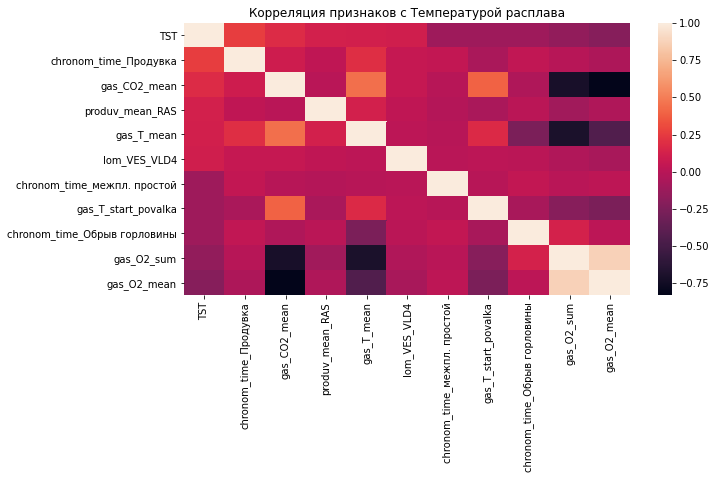

In [159]:
fig, ax = plt.subplots(figsize=(10,5))
cols = ['TST']+tst_corr_features
sns.heatmap(corr.loc[cols,cols], ax=ax)
            
ax.set_title('Корреляция признаков с Температурой расплава')
plt.show()

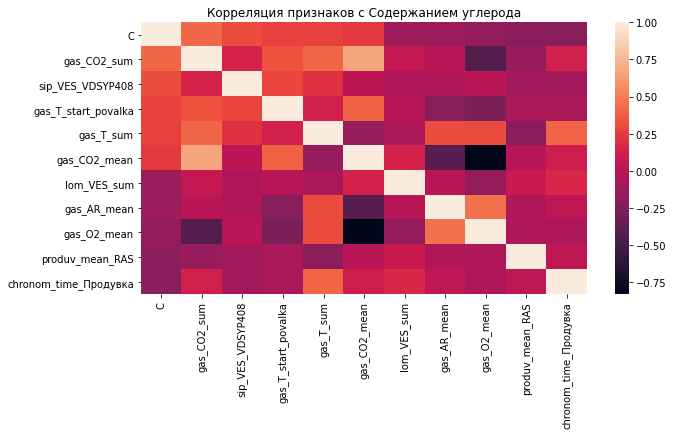

In [160]:
fig, ax = plt.subplots(figsize=(10,5))
cols = ['C']+c_corr_features
sns.heatmap(corr.loc[cols,cols], ax=ax)
            
ax.set_title('Корреляция признаков с Содержанием углерода')
plt.show()

# Предсказание температуры

In [112]:
df_train[targets+tst_corr_features]

,TST,C,chronom_time_Продувка,gas_CO2_mean,produv_mean_RAS,gas_T_mean,lom_VES_VLD4,chronom_time_межпл. простой,gas_T_start_povalka,chronom_time_Обрыв горловины,gas_O2_sum,gas_O2_mean
0,1690,0.060,1170,13.646908,408.181995,506.912198,56500,333,785.416687,0,20685.819848,8.080398
1,1683,0.097,1230,11.761720,437.750429,375.840941,49800,422,846.875000,0,43381.103374,10.985339
2,1662,0.091,1226,12.723079,433.941227,489.881937,45900,307,831.597229,0,25108.381611,8.745518
3,1609,0.410,1058,13.566362,392.992501,439.273874,51900,700,826.041687,541,29401.916247,9.016227
4,1682,0.120,1239,13.643787,396.448585,478.608197,64000,464,809.722229,0,24225.586513,8.470485
...,...,...,...,...,...,...,...,...,...,...,...,...
2056,1626,0.145,1063,17.997605,372.911585,439.574555,51700,470,772.569458,0,12707.545640,4.152793
2057,1643,0.087,1108,12.629975,449.224197,336.801224,46400,765,812.152771,0,31294.109473,8.228796
2058,1615,0.141,1058,13.776500,410.935288,390.420212,41400,442,782.986084,438,22498.203495,6.857118
2059,1654,0.270,1169,14.838620,346.784867,385.978217,59000,454,779.513855,0,21993.862756,6.075653


## Columns tramsforming

In [113]:
df2 = df_train[targets+tst_corr_features]

In [114]:
categorical_selector = make_column_selector(dtype_include=object)
cat_features = categorical_selector(df2)
num_selector = make_column_selector(dtype_include=np.number)
num_features = num_selector(df2)

tst_ct = make_column_transformer(
    (PowerTransformer(), num_features),
    (OneHotEncoder(handle_unknown='ignore'), cat_features),
    remainder='passthrough'
)

In [124]:
tst_ct.named_transformers_

{'powertransformer': PowerTransformer(),
 'onehotencoder': OneHotEncoder(handle_unknown='ignore')}

In [116]:
cat_features

[]

In [123]:
num_features

['TST',
 'C',
 'chronom_time_Продувка',
 'gas_CO2_mean',
 'produv_mean_RAS',
 'gas_T_mean',
 'lom_VES_VLD4',
 'chronom_time_межпл. простой',
 'gas_T_start_povalka',
 'chronom_time_Обрыв горловины',
 'gas_O2_sum',
 'gas_O2_mean']

In [115]:
df_train2 = tst_ct.fit_transform(df2)
df_train2.shape

(2061, 12)

In [162]:
df_train2[:, 2:]

array([[ 0.10596412,  0.66180223, -0.17502005, ..., -0.4326711 ,
        -0.55881951, -0.43273007],
       [ 0.98310972,  0.01287873,  0.47901708, ..., -0.4326711 ,
         0.92026302,  0.51794354],
       [ 0.92325985,  0.34792888,  0.39237041, ..., -0.4326711 ,
        -0.22629763, -0.22096891],
       ...,
       [-1.41329545,  0.70523772, -0.11591865, ...,  2.31298012,
        -0.41888216, -0.81200729],
       [ 0.09171901,  1.05607086, -1.39645295, ..., -0.4326711 ,
        -0.45727661, -1.04681583],
       [ 0.65636377,  0.36690757, -3.32136061, ...,  2.31852434,
         0.89724897, -0.14364097]])

In [208]:
X = df_train2[:, 2:]
y = df_train2[:,0]

In [193]:
model = LassoCV(random_state=313, n_jobs=-1)

scores = cross_val_score(model, X, y, n_jobs=-1, scoring='r2')
scores

array([ 0.14673368,  0.13579262,  0.17556149,  0.1694447 , -0.01265363])

In [209]:
model = LassoCV(random_state=313, n_jobs=-1)

model.fit(X, y)

LassoCV(n_jobs=-1, random_state=313)

In [210]:
model.score(X,y)

0.18348648129018452

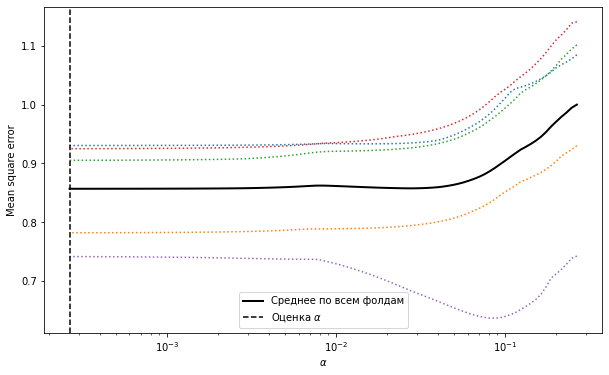

In [211]:
plt.figure(figsize=(10,6))
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Среднее по всем фолдам",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label=r"Оценка $\alpha$"
)

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.show()

In [175]:
model.alphas_[np.argmin(model.mse_path_)], model.mse_path_.min()

(0.000756152175044141, 0.63700206157508)

# Предсказание содержания углерода

In [194]:
df_train[targets+c_corr_features]

,TST,C,gas_CO2_sum,sip_VES_VDSYP408,gas_T_start_povalka,gas_T_sum,gas_CO2_mean,lom_VES_sum,gas_AR_mean,gas_O2_mean,produv_mean_RAS,chronom_time_Продувка
0,1690,0.060,34936.083312,14080,785.416687,1.297695e+06,13.646908,76200,0.801776,8.080398,408.181995,1170
1,1683,0.097,46447.033896,18830,846.875000,1.484196e+06,11.761720,78600,0.838266,10.985339,437.750429,1230
2,1662,0.091,36527.960575,16080,831.597229,1.406451e+06,12.723079,76300,0.828832,8.745518,433.941227,1226
3,1609,0.410,44239.906145,22150,826.041687,1.432472e+06,13.566362,84100,0.835434,9.016227,392.992501,1058
4,1682,0.120,39021.231253,19550,809.722229,1.368819e+06,13.643787,76100,0.802074,8.470485,396.448585,1239
...,...,...,...,...,...,...,...,...,...,...,...,...
2056,1626,0.145,55072.672708,14640,772.569458,1.345098e+06,17.997605,73600,0.736660,4.152793,372.911585,1063
2057,1643,0.087,48031.796573,19210,812.152771,1.280855e+06,12.629975,76600,0.831568,8.228796,449.224197,1108
2058,1615,0.141,45200.696418,19420,782.986084,1.280969e+06,13.776500,64200,0.772488,6.857118,410.935288,1058
2059,1654,0.270,53715.803051,16100,779.513855,1.397241e+06,14.838620,66200,0.743987,6.075653,346.784867,1169


## Columns tramsforming

In [195]:
df3 = df_train[targets+c_corr_features]

In [196]:
categorical_selector = make_column_selector(dtype_include=object)
cat_features = categorical_selector(df3)
num_selector = make_column_selector(dtype_include=np.number)
num_features = num_selector(df3)

c_ct = make_column_transformer(
    (PowerTransformer(), num_features),
    (OneHotEncoder(handle_unknown='ignore'), cat_features),
    remainder='passthrough'
)

In [198]:
cat_features

[]

In [199]:
num_features

['TST',
 'C',
 'gas_CO2_sum',
 'sip_VES_VDSYP408',
 'gas_T_start_povalka',
 'gas_T_sum',
 'gas_CO2_mean',
 'lom_VES_sum',
 'gas_AR_mean',
 'gas_O2_mean',
 'produv_mean_RAS',
 'chronom_time_Продувка']

In [201]:
df_train3 = c_ct.fit_transform(df3)
df_train3.shape

/home/msemezhov/.local/lib/python3.6/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(2061, 12)

In [212]:
X = df_train3[:, 2:]
y = df_train3[:,1]

In [203]:
model_c = LassoCV(random_state=313, n_jobs=-1)

scores = cross_val_score(model_c, X, y, n_jobs=-1, scoring='r2')
scores

array([0.55923806, 0.54319756, 0.48399262, 0.37633262, 0.51345036])

In [204]:
model_c = LassoCV(random_state=313, n_jobs=-1)

model_c.fit(X, y)

LassoCV(n_jobs=-1, random_state=313)

In [205]:
model_c.score(X,y)

0.5232556493585809

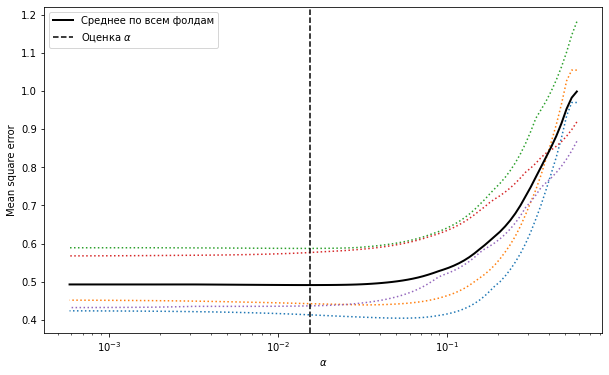

In [213]:
plt.figure(figsize=(10,6))
plt.semilogx(model_c.alphas_, model_c.mse_path_, ":")
plt.plot(
    model_c.alphas_,
    model_c.mse_path_.mean(axis=-1),
    "k",
    label="Среднее по всем фолдам",
    linewidth=2,
)
plt.axvline(
    model_c.alpha_, linestyle="--", color="k", label=r"Оценка $\alpha$"
)

plt.legend()

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.show()